### 1️⃣ Introduction & Objective

# 📚 Synthetic Financial Data Generation: Process & Reasoning

## 🎯 Objective
The original dataset had an imbalance in the `market_stress` target variable, which could lead to biased models favoring the majority class. 
To create a more robust dataset, we generate synthetic financial data that is:

- **Balanced** (`market_stress = 0 and 1`)
- **Statistically consistent** with real data
- **Logically constrained** to maintain economic plausibility

We'll walk through the process step by step, with visualizations to track changes in the data.

### 2️⃣ Load & Explore the Original Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6045 entries, 0 to 6044
Columns: 215 entries, Date to interest rates_lag30
dtypes: float64(213), int64(1), object(1)
memory usage: 9.9+ MB
Class Distribution:
 market_stress
0    5780
1     265
Name: count, dtype: int64


/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_24332/1579383320.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette=["#1f77b4", "#ff7f0e"])


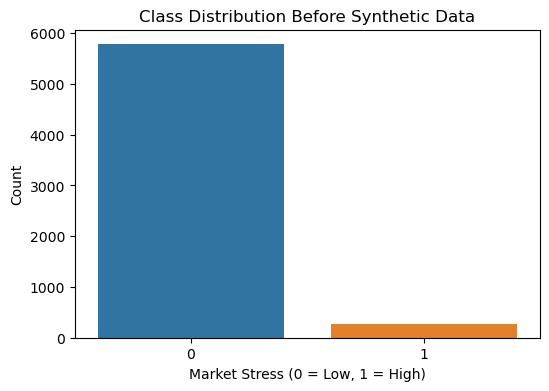

<Figure size 640x480 with 0 Axes>

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("data/financial_data_full.csv")

# Check the structure
df.info()

# Check class distribution
class_counts = df["market_stress"].value_counts()
print("Class Distribution:\n", class_counts)

# Plot Class Imbalance
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=["#1f77b4", "#ff7f0e"])
plt.xlabel("Market Stress (0 = Low, 1 = High)")
plt.ylabel("Count")
plt.title("Class Distribution Before Synthetic Data")
plt.show()

# Save before displaying
plt.savefig("pics/class_distro_before_synth.png", dpi=300, bbox_inches="tight")
plt.show()

### 3️⃣ Strategy for Synthetic Data Generation

## 🛠️ Strategy: Balancing Market Stress

To ensure fair training, we:
1. **Identify underrepresented class** (`market_stress = 1`).
2. **Generate synthetic financial records** for balance:
   - Apply **Gaussian noise** (5% of standard deviation) to features.
   - Maintain **logical constraints** (e.g., inflation cannot be negative).
3. **Merge synthetic and real data** to create a fair dataset.

#### Visualizing Feature Distributions Before Adding Synthetic Data

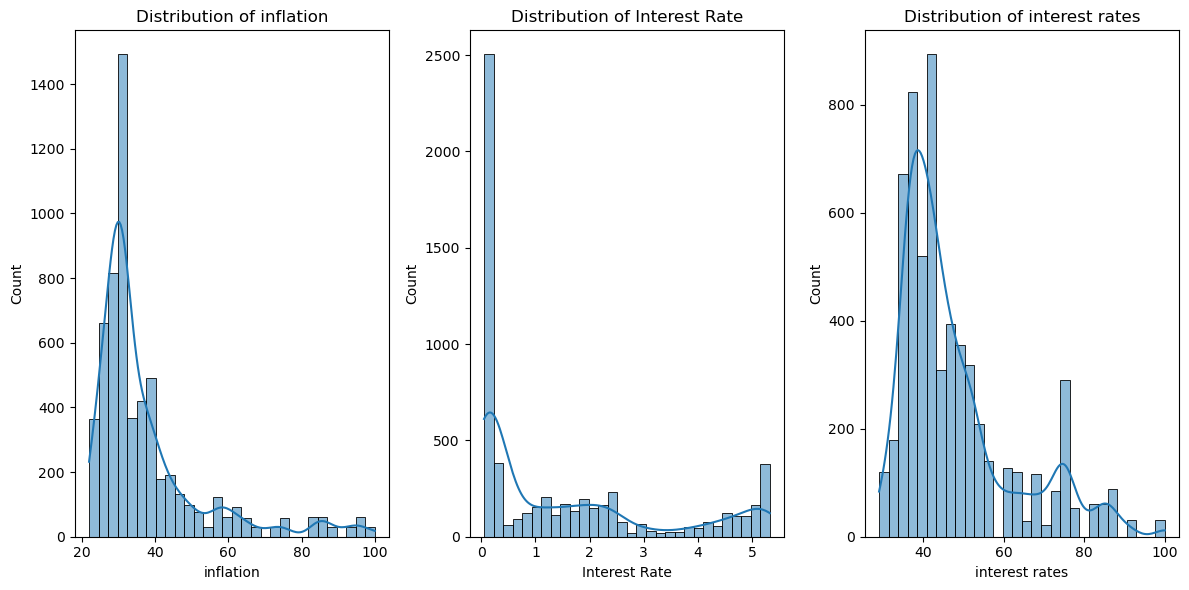

<Figure size 640x480 with 0 Axes>

In [28]:
# Plot feature distributions before adding synthetic data
plt.figure(figsize=(12, 6))
for i, col in enumerate(["inflation", "Interest Rate", "interest rates"]):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

# Save before displaying
plt.savefig("pics/cols_distro.png", dpi=300, bbox_inches="tight")
plt.show()

### 4️⃣ Generate Synthetic Data

In [16]:
# Identify numerical columns (excluding target)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("market_stress")

# Define synthetic data generation function
def generate_synthetic_data(df, target_col="market_stress", n_samples=1000):
    """Generates synthetic financial data for the underrepresented class."""
    df_minority = df[df[target_col] == df[target_col].value_counts().idxmin()]
    
    synthetic_samples = []
    for _ in range(n_samples):
        sample = df_minority.sample(n=1, replace=True).copy()
        for col in num_cols:
            std_dev = df[col].std()
            sample[col] += np.random.normal(0, 0.05 * std_dev)  # Add Gaussian Noise
            
            # Prevent unrealistic negative values
            sample[col] = sample[col].clip(lower=0)

        synthetic_samples.append(sample)

    return pd.concat(synthetic_samples, ignore_index=True)

# Compute number of synthetic samples needed
n_synthetic = abs(class_counts.max() - class_counts.min())

# Generate synthetic samples
df_synthetic = generate_synthetic_data(df, n_samples=n_synthetic)

# Merge original and synthetic data
df_balanced = pd.concat([df, df_synthetic], ignore_index=True)

# Shuffle dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Save synthetic dataset
df_balanced.to_csv("data/synth_findata.csv", index=False)
print("✅ Synthetic dataset saved successfully.")

✅ Synthetic dataset saved successfully.


### 5️⃣ **Visualizing the Impact of Synthetic Data**  

Since market stress isn’t the norm, we expect the dataset was initially imbalanced. **Class distribution before synthetic data confirmed `market_stress = 1` was much rarer**, justifying synthetic data generation to prevent the model from being biased toward the majority class (`market_stress = 0`).  

Time series definitely has an impact, but **we aren’t trying to time the market at a granular level yet**. As **Dr. Gurkaran Buxi, PhD** (Founders Running Club SF / former Quantitative Trader at Tower Research Capital & Hutchin Hill Capital) said regarding **collating sparse events to inform overall trends**:  

> "The effect of social trends has a life cycle of 2.3 seconds. [...] It can be 100bps."  

While short-term trends **burn out quickly**, we are looking at **longer time horizons**—reading the pulse of the general market from disparate, noisy signal inputs.  

Not that correlation is causation—but this week's theme is **quantum physics-inspired accelerational learning** (so, **immediate influence to inform broader market movement**).

#### Class Distribution After Balancing

/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_24332/272132911.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=new_class_counts.index, y=new_class_counts.values, palette=["#1f77b4", "#ff7f0e"])


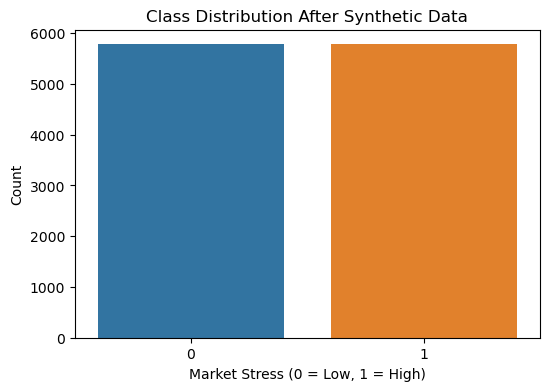

In [18]:
# Check new class distribution
new_class_counts = df_balanced["market_stress"].value_counts()

# Plot Class Distribution After Balancing
plt.figure(figsize=(6,4))
sns.barplot(x=new_class_counts.index, y=new_class_counts.values, palette=["#1f77b4", "#ff7f0e"])
plt.xlabel("Market Stress (0 = Low, 1 = High)")
plt.ylabel("Count")
plt.title("Class Distribution After Synthetic Data")
plt.show()

#### Feature Distributions Before vs. After

/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_24332/2563158771.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], label="Original", shade=True, alpha=0.5)
/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_24332/2563158771.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_balanced[col], label="With Synthetic", shade=True, alpha=0.5)
/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_24332/2563158771.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], label="Original", shade=True, alpha=0.5)
/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_24332/2563158771.py:

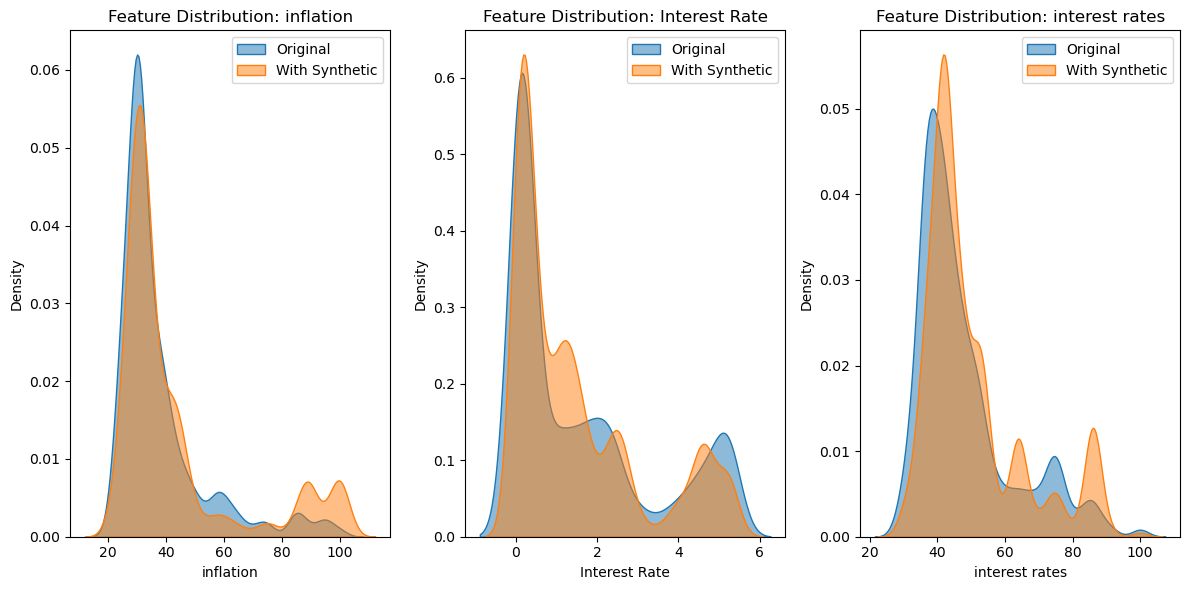

<Figure size 640x480 with 0 Axes>

In [26]:
# Compare distributions before & after
plt.figure(figsize=(12, 6))
for i, col in enumerate(["inflation", "Interest Rate", "interest rates"]):
    plt.subplot(1, 3, i+1)
    sns.kdeplot(df[col], label="Original", shade=True, alpha=0.5)
    sns.kdeplot(df_balanced[col], label="With Synthetic", shade=True, alpha=0.5)
    plt.title(f"Feature Distribution: {col}")
    plt.legend()

plt.tight_layout()
plt.show()

# Save before displaying
plt.savefig("pics/feat_distro.png", dpi=300, bbox_inches="tight")
plt.show()

#### 2D PCA Projection to Check Synthetic Data Similarity

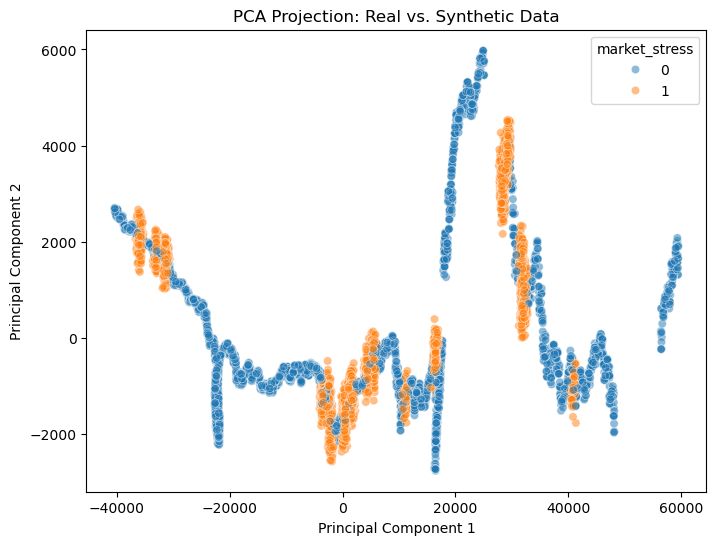

<Figure size 640x480 with 0 Axes>

In [24]:
from sklearn.decomposition import PCA

# Fit PCA for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_balanced[num_cols])

# Scatter plot of PCA-transformed data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_balanced["market_stress"], palette=["#1f77b4", "#ff7f0e"], alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection: Real vs. Synthetic Data")
plt.show()

# Save before displaying
plt.savefig("pics/pca_projection.png", dpi=300, bbox_inches="tight")
plt.show()